# Structure of KineticEEG Program
The structure of this computer program is in the following pipeline:


## Data Aquisition->Processing->Featurization(Polynomial Fitting)->Classification

BaseEEG-Interface with Emotiv EEG Headset(Data Aquisition and Processing)
-----------------------------------------------------------------------------


This is a portion of the code which interacts with Emotiv APIs to extract and process the incoming raw EEG stream. The code is implemented such that multiprocessing is possible. This file makes use of the `ctypes` library in order to communicate with the API.

# The `EmotivDataGetter` Class
## The `EmotivDataGetter.__init__()` method
The `EmotivDataGetter` class contains all the necessary declarations and constants to communicate with the Emotiv API. It defines the codes needed to request and interpret the data by defining the `ED_X` constants. It also tunes the options needed to set up the data session and creates the buffers in the `__init__`method.

## The mainloop-`self.scanloop()`
The class implements a mainloop function in order to start the process of gathering the Emotiv data. This is done through `scanloop` function which repeatedly recieves `libEDK.eEvent`s and then extracts the data by monitoring the size of the data buffer. 



# The `EEG_Processer` Class
## The `EEG_Processer.__init__` method
This is a method which implements the initialization of the data structures needed in order to correctly and safely process the data. 
## The `EEG_Proceesser.mainloop()` method.
This method takes, as its arguments interprocess communication pipes to facilitate the transfer of data in between processes running in parallel. It takes in the data from the `EmotivDataGetter` instance running process and sends processed data down the IPC pipe to the classifier(in data packets). These are both parallelised systems.




In [ ]:
# %load C:\Users\Gaurav\Documents\GitHub\KineticEEG\KineticEEG\BaseEEG.py



import ctypes

import sys
import os
import tkinter
import multiprocessing 
from ctypes import *
import PreprocessUtils
import numpy
from numpy import *
import time
from ctypes.util import find_library
os.chdir("C:/Program Files (x86)/Emotiv Research Edition SDK v2.0.0.20/dll/32 bit/")
libEDK = cdll.LoadLibrary("edk.dll")
def run_data_getter_processer(q):
    j=EmotivDataGetter()
    j.scan_loop(q)
    j.cleanup()
    
class EmotivDataGetter:
    ED_COUNTER = 0
    ED_INTERPOLATED=1
    ED_RAW_CQ=2
    ED_AF3=3
    ED_F7=4
    ED_F3=5
    ED_FC5=6
    ED_T7=7
    ED_P7=8
    ED_O1=9
    ED_O2=10
    ED_P8=11
    ED_T8=12
    ED_FC6=13
    ED_F4=14
    ED_F8=15
    ED_AF4=16
    ED_GYROX=17
    ED_GYROY=18
    ED_TIMESTAMP=19
    ED_ES_TIMESTAMP=20
    ED_FUNC_ID=21
    ED_FUNC_VALUE=22
    ED_MARKER=23
    ED_SYNC_SIGNAL=24
    def __init__(self):
            #q.put("Hi")
            self.targetChannelList = [EmotivDataGetter.ED_COUNTER,EmotivDataGetter.ED_INTERPOLATED,
                                        EmotivDataGetter.ED_RAW_CQ,EmotivDataGetter.ED_AF3, EmotivDataGetter.ED_F7,EmotivDataGetter.ED_F3, EmotivDataGetter.ED_FC5, EmotivDataGetter.ED_T7,
                                    EmotivDataGetter.ED_P7, EmotivDataGetter.ED_O1, EmotivDataGetter.ED_O2, EmotivDataGetter.ED_P8,EmotivDataGetter.ED_T8,EmotivDataGetter.ED_FC6, EmotivDataGetter.ED_F4,
                                   EmotivDataGetter.ED_F8,EmotivDataGetter.ED_AF4, EmotivDataGetter.ED_GYROX, EmotivDataGetter.ED_GYROY, EmotivDataGetter.ED_TIMESTAMP, EmotivDataGetter.ED_FUNC_ID,
                                   EmotivDataGetter.ED_FUNC_VALUE, EmotivDataGetter.ED_MARKER, EmotivDataGetter.ED_SYNC_SIGNAL]
##            self.targetChannelList = [EmotivDataGetter.ED_AF3, EmotivDataGetter.ED_F7,EmotivDataGetter.ED_F3, EmotivDataGetter.ED_FC5, EmotivDataGetter.ED_T7,
##                                      EmotivDataGetter.ED_P7, EmotivDataGetter.ED_O1, EmotivDataGetter.ED_O2, EmotivDataGetter.ED_P8,EmotivDataGetter.ED_T8,EmotivDataGetter.ED_FC6, EmotivDataGetter.ED_F4,
##                                      EmotivDataGetter.ED_F8,EmotivDataGetter.ED_AF4]
            self.header = ['COUNTER','AF3','F7','F3', 'FC5', 'T7', 'P7', 'O1', 'O2','P8', 'T8', 'FC6', 'F4','F8', 'AF4','GYROX', 'GYROY', 'TIMESTAMP','FUNC_ID', 'FUNC_VALUE', 'MARKER', 'SYNC_SIGNAL']
            self.sens=['c','int', 'cq', 'AF3','F7','F3', 'FC5', 'T7', 'P7', 'O1', 'O2','P8', 'T8', 'FC6', 'F4','F8', 'AF4']
            self.eEvent=libEDK.EE_EmoEngineEventCreate()
            self.eState= libEDK.EE_EmoStateCreate()
            #print("Hi")
            self.userID =c_uint(0)
            self.nSamples=c_uint(0)
            self.nSam= c_uint(0)
            self.nSamplesTaken  = pointer(self.nSamples)
            self.dct1={}
            for i in self.sens:
                self.dct1[i]=[]
            self.da= zeros(128,double)
            self.data= pointer(c_double(0))
            self.user= pointer(self.userID)
            self.composerPort= c_uint(1726)
            self.secs= c_float(1)
            self.datarate= c_uint(0)
            self.readytocollect  = False
            self.option= c_int(0)
            self.state= c_int(0)
            libEDK.EE_EngineConnect(b"Emotiv Systems-5")
            self.hData = libEDK.EE_DataCreate()
            libEDK.EE_DataSetBufferSizeInSec(4)
            #q.put("Connected")
            
    def scan_example(self,q):
        x=int()
        while True:
            q.put(x)
            x+=1
            time.sleep(8/128)
    def test_parallel_withq(self,q):
        first_iter=bool(True)
        try:
            while True :
                for i in self.sens:
                    self.dct1[i]=[]
                state = libEDK.EE_EngineGetNextEvent(self.eEvent)
                if state == 0:
                    eventType = libEDK.EE_EmoEngineEventGetType(self.eEvent)
                    libEDK.EE_EmoEngineEventGetUserId(self.eEvent, self.user)
                    if eventType == 16: #libEDK.EE_Event_enum.EE_UserAdded:
                        libEDK.EE_DataAcquisitionEnable(self.userID,True)
                        self.readytocollect = True
                if self.readytocollect==True:    
                    libEDK.EE_DataUpdateHandle(0, self.hData)
                    libEDK.EE_DataGetNumberOfSample(self.hData,self.nSamplesTaken)
                    if first_iter:
                        if self.nSamplesTaken[0] != 0:
                            self.nSam=self.nSamplesTaken[0]
                            arr=(ctypes.c_double*self.nSamplesTaken[0])()
                            ctypes.cast(arr, ctypes.POINTER(ctypes.c_double))                      
                            data = array('d')
                            useless=list(self.targetChannelList.keys())
                            for sampleIdx in range(self.nSamplesTaken[0]): 
                                for i in self.targetChannelList:
                                    libEDK.EE_DataGet(hData,useless.index(i),byref(arr), nSam)
                                    self.dct1[i].append(arr[sampleIdx])
                                if len(self.dct1["F3"])==512:
                                    q.put(self.dct1)
                                    first_iter=False
                    else:
                        if self.nSamplesTaken==16:
                            self.nSam=self.nSamplesTaken[0]
                            arr=(ctypes.c_double*self.nSamplesTaken[0])()
                            ctypes.cast(arr, ctypes.POINTER(ctypes.c_double))                  
                            data = array('d')
                            for sampleIdx in range(self.nSamplesTaken[0]): 
                                for i in self.sens: 
                                    libEDK.EE_DataGet(hData,i,byref(arr), nSam)
                                    self.dct1[i].append(arr[sampleIdx])
                                if len(self.dct1["F3"])==512:
                                    q.put(self.dct1)
                                    first_iter=False
                
        except:
            q.put("die")
            self.cleanup()
    def scan_loop(self,q):
        first_iter=bool(True)
        for i in self.sens:
            self.dct1[i]=[]
        try:
            while True :
                state = libEDK.EE_EngineGetNextEvent(self.eEvent)
                if state == 0:
                    eventType = libEDK.EE_EmoEngineEventGetType(self.eEvent)
                    libEDK.EE_EmoEngineEventGetUserId(self.eEvent, self.user)
                    if eventType == 16: #libEDK.EE_Event_enum.EE_UserAdded:
                        libEDK.EE_DataAcquisitionEnable(self.userID,True)
                        self.readytocollect = True
                if self.readytocollect==True:
                    #print("ready")
                    if first_iter:
                        #print("Now", time.time())
                        while not self.nSamplesTaken[0]>=512:
                            libEDK.EE_DataUpdateHandle(0, self.hData)
                            libEDK.EE_DataGetNumberOfSample(self.hData,self.nSamplesTaken)
                          #  print(self.nSamplesTaken[0])
                            time.sleep(float(512.0-self.nSamplesTaken[0])/128.0)
                            libEDK.EE_DataUpdateHandle(0, self.hData)
                            libEDK.EE_DataGetNumberOfSample(self.hData,self.nSamplesTaken)
                        #print(self.nSamplesTaken[0], time.time())
                        if self.nSamplesTaken[0]==512:
                            self.nSam=self.nSamplesTaken[0]
                            arr=(c_double*512)()
                            libEDK.EE_DataGetNumberOfSample(self.hData,self.nSamplesTaken)
                            ctypes.cast(arr, ctypes.POINTER(ctypes.c_double))                      
                            data = array('d')
                            useless=list(self.sens)
                            for sampleIdx in range(self.nSamplesTaken[0]): 
                                for i in range(3, 17):
                                    libEDK.EE_DataGet(self.hData,i,byref(arr), self.nSam)
                                    self.dct1[self.sens[i]].append(arr[sampleIdx])
                                if len(self.dct1["FC5"])==512:
                                    q.send(self.dct1)
                                   # eefe=open("C:/Users/Gaurav/Desktop/gatherside.txt", "w")
                                    #eefe.write(str(self.dct1))
                                    #eefe.close()
                                    first_iter=False
                                    for i in self.sens:
                                        self.dct1[i]=[]
                    count=0
                    while True:
                      imi=time.time()
                     
                      libEDK.EE_DataUpdateHandle(0, self.hData)
                      libEDK.EE_DataGetNumberOfSample(self.hData, self.nSamplesTaken)
                      #print(self.nSamplesTaken[0], time.time())
                      #while not self.nSamplesTaken[0]==16:
                          #libEDK.EE_DataUpdateHandle(0, self.hData)
                         # libEDK.EE_DataGetNumberOfSample(self.hData, self.nSamplesTaken)
                       #   print(self.nSamplesTaken[0])
                      if self.nSamplesTaken[0]!=0:
                           # libEDK.EE_DataUpdateHandle(0, self.hData)
                            self.nSam=self.nSamplesTaken[0]
                            arr=(c_double*self.nSamplesTaken[0])()
                            ctypes.cast(arr, ctypes.POINTER(ctypes.c_double))                  
                            data = array('d')
                            useless=list(self.sens)
                            time.sleep(0.125-(time.time()-imi))
                            for sampleIdx in range(self.nSamplesTaken[0]): 
                                for i in self.sens: 
                                    libEDK.EE_DataGet(self.hData,useless.index(i),byref(arr), self.nSam)
                                    #print("jo", len(self.dct1["FC5"]))
                                    self.dct1[i].append(arr[sampleIdx])
                                count+=1
                                if count==16:
                                    q.send(self.dct1)
                                    #q.put(len(self.dct1["FC5"]))
                                    
                                    #eefe=open("C:/Users/Gaurav/Desktop/gatherside.txt", "a")
                                    #eefe.write("\n")
                                    #eefe.write("\n")
                                    #eefe.write(str(len(self.dct1["FC5"])))
                                    #eefe.write("\n")
                                    #eefe.write(str(self.dct1))
                                    #eefe.close()
                                    #print("Hi", time.time())
                                    for i in self.sens:
                                        count=0
                                        self.dct1[i]=[]
                            
        except:
            
            self.cleanup()
            q.close()
            raise
        
    def scan_loop1(self,q):
        first_iter=bool(True)
        for i in self.sens:
            self.dct1[i]=[]
        try:
            while True :
                state = libEDK.EE_EngineGetNextEvent(self.eEvent)
                if state == 0:
                    eventType = libEDK.EE_EmoEngineEventGetType(self.eEvent)
                    libEDK.EE_EmoEngineEventGetUserId(self.eEvent, self.user)
                    if eventType == 16: #libEDK.EE_Event_enum.EE_UserAdded:
                        libEDK.EE_DataAcquisitionEnable(self.userID,True)
                        self.readytocollect = True
                if self.readytocollect==True:
                    #print("ready")
                    if first_iter:
                        #print("Now", time.time())
##                        while not self.nSamplesTaken[0]!=512:
##                            time.sleep(1)
##                            libEDK.EE_DataUpdateHandle(0, self.hData)
                        libEDK.EE_DataGetNumberOfSample(self.hData,self.nSamplesTaken)
                            
                        #print(self.nSamplesTaken[0], time.time())
                        if self.nSamplesTaken[0]!=0:
                            self.nSam=self.nSamplesTaken[0]
                            arr=(c_double*512)()
                            libEDK.EE_DataGetNumberOfSample(self.hData,self.nSamplesTaken)
                            ctypes.cast(arr, ctypes.POINTER(ctypes.c_double))                      
                            data = array('d')
                            useless=list(self.sens)
                            for sampleIdx in range(self.nSamplesTaken[0]): 
                                for i in self.sens:
                                    libEDK.EE_DataGet(self.hData,useless.index(i),byref(arr), self.nSam)
                                    self.dct1[i].append(arr[sampleIdx])
                                if len(self.dct1["FC5"])==512:
                                    q.send(self.dct1)
                                   # eefe=open("C:/Users/Gaurav/Desktop/gatherside.txt", "w")
                                    #eefe.write(str(self.dct1))
                                    #eefe.close()
                                    first_iter=False
                                    for i in self.sens:
                                        self.dct1[i]=[]
                    count=0
                    while True:
                      #print(time.time())
                      ##time.sleep(0.025*0.75)
                      libEDK.EE_DataUpdateHandle(0, self.hData)
                      libEDK.EE_DataGetNumberOfSample(self.hData, self.nSamplesTaken)
                      #print(self.nSamplesTaken[0], time.time())
                      #while not self.nSamplesTaken[0]==16:
                          #libEDK.EE_DataUpdateHandle(0, self.hData)
                         # libEDK.EE_DataGetNumberOfSample(self.hData, self.nSamplesTaken)
                       #   print(self.nSamplesTaken[0])
                      if self.nSamplesTaken[0]!=0:
                           # libEDK.EE_DataUpdateHandle(0, self.hData)
                            self.nSam=self.nSamplesTaken[0]
                            arr=(c_double*self.nSamplesTaken[0])()
                            ctypes.cast(arr, ctypes.POINTER(ctypes.c_double))                  
                            data = array('d')
                            useless=list(self.sens)
                            for sampleIdx in range(self.nSamplesTaken[0]): 
                                for i in self.sens: 
                                    libEDK.EE_DataGet(self.hData,useless.index(i),byref(arr), self.nSam)
                                    #print("jo", len(self.dct1["FC5"]))
                                    self.dct1[i].append(arr[sampleIdx])
                                count+=1
                                if count==16:
                                    q.send(self.dct1)
                                    #q.put(len(self.dct1["FC5"]))
                                    
                                    #eefe=open("C:/Users/Gaurav/Desktop/gatherside.txt", "a")
                                    #eefe.write("\n")
                                    #eefe.write("\n")
                                    #eefe.write(str(len(self.dct1["FC5"])))
                                    #eefe.write("\n")
                                    #eefe.write(str(self.dct1))
                                    #eefe.close()
                                    #print("Hi", time.time())
                                    for i in self.sens:
                                        count=0
                                        self.dct1[i]=[]
                            
        except:
            
            self.cleanup()
            q.close()
            raise
        
                
    def cleanup(self):
        libEDK.EE_DataFree(self.hData)
        libEDK.EE_EngineDisconnect()
        libEDK.EE_EmoStateFree(self.eState)
        libEDK.EE_EmoEngineEventFree(self.eEvent)
def exec_proc(q,putq,samps):
    t=EEG_Processer()
    try:
        t.mainloop(q, putq, samps)
    except:
        a=open("C:/Users/Gaurav/Desktop/errors.txt", "w")
        a.write("ERROR")
        
        a.close()
        a=open("C:/Users/Gaurav/Desktop/errors.txt", "w")
        
        sys.stderr=a
        raise
        
class EEG_Processer:
    def __init__(self):
        self.sensors= ['F3', 'O2', 'O1', 'F8', 'F4', 'FC6', 'AF3', 'P7', 'P8', 'FC5', 'T8', 'AF4', 'F7', 'T7']
    def mainloop_example(self, q, q2, st):
        while True:
            j=q.get()
            q2.put(j)
    def mainloop(self, q,q2,st):
        j={'F3':[], 'O2':[], 'O1':[], 'F8':[], 'F4':[], 'FC6':[], 'AF3':[], 'P7':[], 'P8':[], 'FC5':[], 'T8':[], 'AF4':[], 'F7':[], 'T7':[]}
        b={}
        #q2.put("Hi")
        firstdat=q.recv()
        #fileh=open("C:/Users/Gaurav/Desktop/Testlogs.txt", "w")
        #fileh.write(str(firstdat))
        #fileh.close()
        #q2.put('Hi')
        if type(firstdat)==str:q2.put(firstdat)
        #if firstdat=="j":q2.put("j")
        for i in self.sensors:
            current=firstdat[i]
            b[i]=current
            artree=PreprocessUtils.highpass(current)
            win32=numpy.hanning(512)
            artree=numpy.array(artree)
            stuff1=win32*artree
            stuff2=PreprocessUtils.bin_power(stuff1, [1,4,8,12,30], 128)
            stuff4=abs(20*numpy.log(stuff2))
            stuff5=tuple(stuff4[0])
            j[i].append(stuff5)
            #time.sleep(16/128)
        q2.send(j)
        while True:
            
            secondat=q.recv()
            #q2.send("recieved one")
            #fileh=open("C:/Users/Gaurav/Desktop/Testlogs.txt", "w")
            #fileh.write(str(secondat))
            #fileh.close()
            #q2.put('Hi')
            if type(secondat)==str:q2.put(secondat)
            #if str(secondat)=="die": q2.put("die");break
            for i in self.sensors:
                current=b[i]
                del current[0:16]
                current+=secondat[i]
                #q2.put(len(current))
                b[i]=current
                artree=PreprocessUtils.highpass(current)
                #q2.send("Highpass")
                win32=numpy.hanning(512)
                artree=numpy.array(artree)
                stuff1=win32*artree
                stuff2=PreprocessUtils.bin_power(stuff1, [1,4,8,12,30], 128)
                stuff4=abs(20*numpy.log(stuff2))
                stuff5=tuple(stuff4[0])
                j[i].append(stuff5)
                #time.sleep(16/128)
            #if len(j["FC5"])==st:
            q2.send(j)
            for i in j.keys():
                j[i]=[]

    

__version__=1.0
__author__="Gaurav Ghosal"        
                        
    

    


A Look At the Data
--------------------


The utility to view the the data through various graphs. The way of doing this is to analyze the various patterns in the data. It can also be used in order to check whether there is distinguishability amongst the different sensors and types of data.This makes extensive use of the `matplotlib` library.

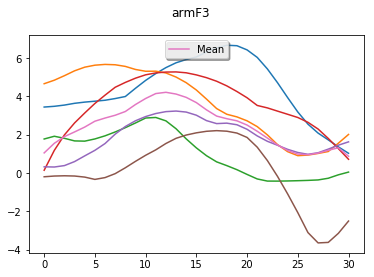

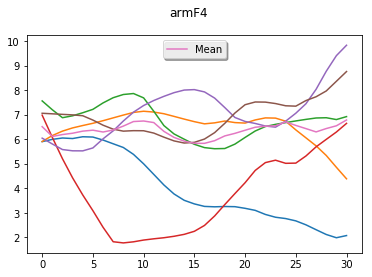

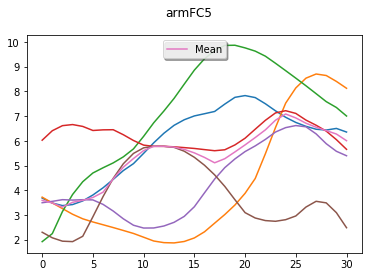

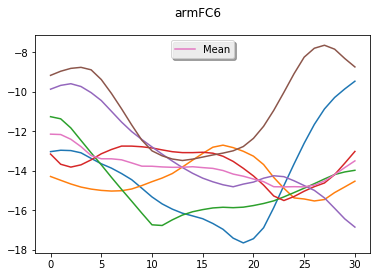

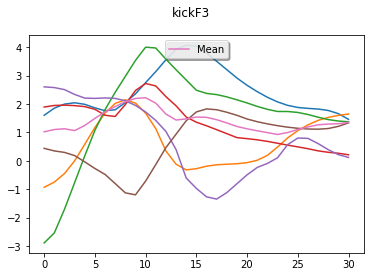

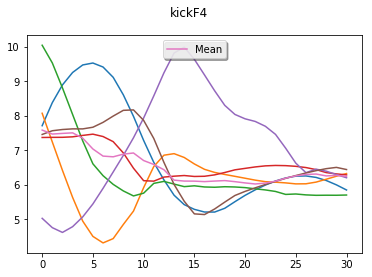

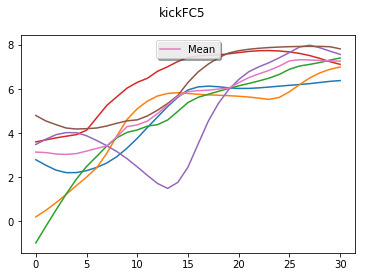

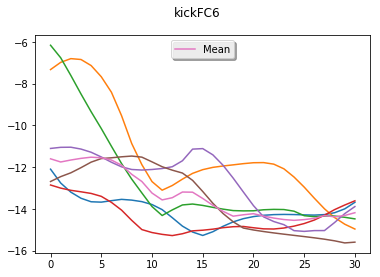

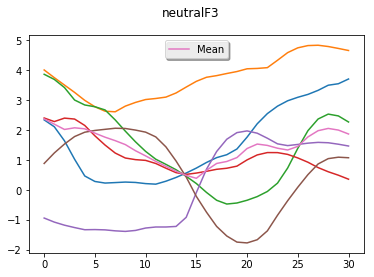

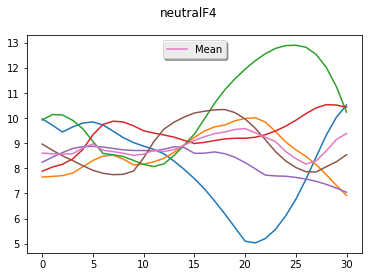

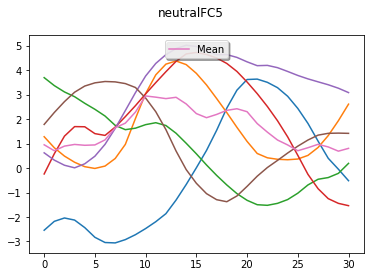

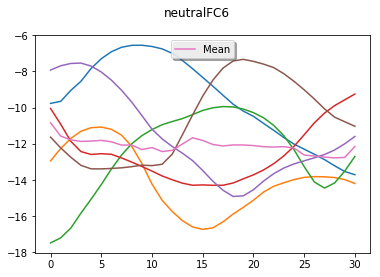

In [1]:
# %load C:\Users\Gaurav\Documents\GitHub\KineticEEG\KineticEEG\Plot.py
#Plots.py

import matplotlib.pyplot
import pickle
import numpy
import itertools
import ClassifyUtils
import statistics
import numpy.polynomial as poly
#from Polyfit222 import Sample
import matplotlib.pyplot as plt

import numpy
class Sample:
    def __init__(self, label, data):
        self.data=data
        self.label=label
    def euclidean_distance_between(self, other):
        tote=0
        for i in self.data:
            tote+=ClassifyUtils.euclideandistance(self.data[i].coef, other.data[i].coef, len(self.data[i].coef))
        return tote
#Load files
def average_distance_from_rulevector(filename, deg):
    fileobj=open(filename, "rb")
    results=dict()
    dat=pickle.loads(fileobj.read())
    labels=list()
    data=list()
    actions=["arm", "kick",'neutral']
    data_to_plot=[]
    distance_data=dict()
    for i in actions:
        distance_data[i]=[]
    labels=[]
    rule=dict()
    average_clustering={"F3":[], "F4":[], "FC5":[], "FC6":[]}
    mat=dict()
    for i in actions:results.update({i:{"F3":[], "F4":[], "FC5":[], "FC6":[]}})
    for i in actions:mat.update({i:{"F3":[], "F4":[], "FC5":[], "FC6":[]}})
    for b in actions:
        for c in dat[b]:
            #for j in c.data:
                for p in c.data:
                    mat[b][p].append(poly.polynomial.Polynomial(poly.polynomial.polyfit(list(range(len(c.data[p]))), c.data[p], deg)))
                    
    #print(len(mat['kick']['F3']))
    for i in ['arm', 'kick', 'neutral']:
        for q in mat[i]:
            initlist=[]
            for p in itertools.combinations(mat[i][q], 2):
                print(p)
                initlist.append(ClassifyUtils.euclideandistance(p[0].coef, p[1].coef, len(p[0].coef)))
            average_clustering[q].append(statistics.mean(initlist))
    for i in ['arm', 'kick', 'neutral']:
        #print(average_clustering)
        minimum_sensor=min(average_clustering, key=lambda x:statistics.mean(average_clustering[x]))
        #print(minimum_sensor)
        matr=numpy.matrix([p.coef for p in mat[i][minimum_sensor]])
        finalrule=list()
        for j in matr.T:
            finalrule.append(statistics.mean(numpy.array(j).flatten()))
        rule[i]={minimum_sensor:finalrule}
    for action_to_test in ['arm', 'kick', 'neutral']:
        
        for sample in mat[action_to_test][list(rule[action_to_test].keys())[0]]:
            #print(sample)
            #print("Action to test", rule[action_to_test])
            labels.append(action_to_test)
            #data.append(ClassifyUtils.euclideandistance(rule[action_to_test][list(rule[action_to_test].keys())[0]], sample.coef, len(sample.coef)))
            distance_data[action_to_test].append(ClassifyUtils.euclideandistance(rule[action_to_test][list(rule[action_to_test].keys())[0]], sample.coef, len(sample.coef)))
            
    ##Make the Plot
    plt.suptitle("Distance to Rule Vector from Samples")
    fig=plt.figure(1, figsize=(20,6))
    ax=fig.add_subplot(111)
    for i in ['arm', 'kick', 'neutral']:
        data.append([distance_data[i]])
    print(len(data))
    bp=ax.boxplot(data, labels=['arm', 'kick', 'neutral'])
    fig.show()
    
    
            
            
        
        
        
        
        
def run_clusteringplot(filename,deg):
    fileobj=open(filename, "rb")
    results=dict()
    dat=pickle.loads(fileobj.read())
    actions=["arm", "kick",'neutral']
    data_to_plot=[]
    labels=[]
    mat=dict()
    for i in actions:results.update({i:{"F3":[], "F4":[], "FC5":[], "FC6":[]}})
    for i in actions:mat.update({i:{"F3":[], "F4":[], "FC5":[], "FC6":[]}})
    for b in actions:
        for c in dat[b]:
            #for j in c.data:
                for p in c.data:
                    mat[b][p].append(poly.polynomial.Polynomial(poly.polynomial.polyfit(list(range(len(c.data[p]))), c.data[p], deg)))
    for i in actions:
        #print(i)
        for j in mat[i]:
            #print(j)
            initlist=[]
            for p in itertools.combinations(mat[i][j], 2):
                initlist.append(ClassifyUtils.euclideandistance(p[0].coef, p[1].coef, len(p[1].coef)))

            data_to_plot.append(initlist)
            labels.append(i+j)
    plt.suptitle(filename.split("/")[-1]+" "+"Average Clustering of Data")
    fig=plt.figure(1, figsize=(20,60))
    ax=fig.add_subplot(111)
    bp=ax.boxplot(data_to_plot, labels=labels)
    fig.show()
def run_data_plot(filename):
    fileobj=open(filename, "rb")
    results=dict()
    main_dict={"arm":{"F3":[], "F4":[], "FC5":[], "FC6":[]}, "kick":{"F3":[], "F4":[], "FC5":[], "FC6":[]}, "neutral":{"F3":[], "F4":[], "FC5":[], "FC6":[]}}
    dat=pickle.loads(fileobj.read())
    fg=plt.figure(1)
    meanlist={"arm":{"F3":[], "F4":[], "FC5":[], "FC6":[]}, "kick":{"F3":[], "F4":[], "FC5":[], "FC6":[]}, "neutral":{"F3":[], "F4":[], "FC5":[], "FC6":[]}}
    std_dict={"arm":{"F3":[], "F4":[], "FC5":[], "FC6":[]}, "kick":{"F3":[], "F4":[], "FC5":[], "FC6":[]}, "neutral":{"F3":[], "F4":[], "FC5":[], "FC6":[]}}
    for i in dat:
        for p in dat[i]:
            for d in p.data:
                main_dict[i][d].append(p.data[d])
                #print(len(p.data[d]))
                
    
    for i in main_dict:
        for j in main_dict[i]:
            #plt.figure()
            fig, ax=plt.subplots()
            for t in main_dict[i][j]:
                plt.plot(t)
                pass
            average_matrix=numpy.matrix([t for t in main_dict[i][j]])
            final_list=list()#Average all the signals
            std=list()#Hold the standard deviations of all the signals.
            
            for pro in average_matrix.T:
                #print(i.flatten().tolist())
                final_list.append(statistics.median(pro.tolist()[0]))
                std.append(abs(statistics.stdev(pro.tolist()[0])/statistics.median(pro.tolist()[0])))
            meanlist[i][j]=final_list
            #print(i+j, str(str(statistics.mean(std))+"+/-"+str(statistics.stdev(std))))
            std_dict[i][j]=statistics.mean(std)

                
            ax.plot(final_list, label='Mean')
            legend = ax.legend(loc='upper center', shadow=True)
                
            
            plt.suptitle(i+j)
            plt.draw()
    for i in std_dict:
        #print(std_dict[i])
        #print(min(std_dict[i], key=lambda x:std_dict[i][x]))
        sens=min(std_dict[i], key=lambda x:std_dict[i][x])
        
        pt=numpy.polyfit(range(0, len(meanlist[i][sens])), meanlist[i][sens], 4)
        #print(i+sens, pt)
    plt.show()
    
        
        


if __name__=='__main__':
    run_data_plot("C:/Users/Gaurav/Desktop/KineticEEGProgamFiles/Trainingdata.kineegtr")
    #run_data_plot("C:/Users/Gaurav/Desktop/KineticEEGProgamFiles/Trainingdata.kineegtr")


# Classification Algorithm

## Channel Selection

When dealing with noisy data, as in the data exposed by the Emotive headset, it becomes necessary to exclude some information. By ignoring the input of potentially random or erronous data, the classifier can get a better idea of the ways in which various data sources contribute or hinder the data. In this project, I attempted to use two metrics for deciding how important data was. 

    1. Clustering of Data(Minimal Intraclass Variation). In order to determine which sensors are producing the most useful output, it is necessary for these sensors to be consistently creating a signature which is present in all of the data. By recognizing which sensors show a consistent pattern for a given action, we can infer that this is related to the action.
    2. Distinguishability(Maximal Interclass Variation). However, it is also crucial to ensure that the sensors are telling unique information about the data. If a recurrent pattern is present in *all* the samples, this does not give very useful information at all!
    

## Featurization-Polynomial Fitting

Featurization 
-------------- 
Featurization is the method in which data is transformed into vectors which can highlight certain aspects of the data. Uses of featurization include _dimensionality reduction_ and the removal of noise from data sources. The use of features also allows the quantification of properties of data. 

Polynomial Fit
-------------------------

Data can be fit to a polynomial of a given degree through the usage of a polynomial fitting algorithm. Given a two dimensional set of points and a given degree, polynomial fitting functions return the coefficients of a polynomial which would best fit the data. In this project, the polynomial fitting function is used to retrieve a vector of fit coefficients which is used as the feature vector of the data. 



Euclidean Distance between Vectors 
----------------------------------

Feature vectors can be treated as geometric vectors in an $n-$ dimensional space. Thus the generalization of the Pythagorean Theorem based distance formula can be used between two points, $a$ and $b$ in an $n-$ dimensional space.

$d(a,b)=\sqrt{\displaystyle\sum_{i=0}^n (a_i-b_i)}$    



# $k-$Nearest Neighbor Algorithm

The $k-$Nearest Neighbor Algorithm is a simple classification algorithm. Essentially, it takes a training set and then classifies a point by finding which classes the closest points to the testing point. The $k-$Nearest Neighbor algorithm makes extensive use of the euclidean distance,and employs _lazy learning_ in which there is not a large amount of work done with the training. The $k-$nearest neighbor algorithm can be used with both raw data, or featurized data. Featurized data has the advantage of not being very high dimensional. 

In [ ]:
%run python Plot.py C:/Users/Gaurav/Desktop/

# Cross Correlation






$norm\_corr(x,y)=\dfrac{\sum_{n=0}^{n-1} x[n]*y[n]}{\sqrt{\sum_{n=0}^{n-1} x[n]^2 * \sum_{n=0}^{n-1} y[n]^2}}$


This formula gives the normalized cross correlation between two signals. The cross correlation can be treated as a measure of similarity between two signals. It is normalized to correct for differences in signal energy. The result is a measure in the interval $\lbrack -1,1 \rbrack$ which tells the correlation of the two symbols. The value of  $1$  indicates identical signals while $-1$ indicates exactly opposite signals. A python/numpy implementation of this measure is given:

`    
def normalized_cross_correlation(sig1,sig2):
	numerator=0
	for i in range(len(sig1)):
		numerator+=((sig1[i]-statistics.mean(sig1))*(sig2[i]-statistics.mean(sig2)))
	sig2denominator=0
	sig1denom=0
	for j in range(len(sig1)):
		sig2denominator+=pow((sig2[j]-statistics.mean(sig2)), 2)
		sig1denom+=pow((sig2[j]-statistics.mean(sig2)), 2)
	denominator=pow(sig2denominator, 0.5)*pow(sig1denom, 0.5)
	return numerator/denominator `
    
    
This measure allows a controlled way of finding out the similarity between two signals. Because of the normalization, different signals can be compared using the cross correlation algorithm. This 


# Evaluation of the Methods